# How to Clean MapBiomas LULC Rasters for any Region in Pyhton?

A raster is a photo in which each pixel reveals information about a specific location. They are usually .tif files and are useful for gathering georeferenced data. In this tutorial, we will save, clean, and plot MapBiomas Land Use Land Cover (LULC) rasters in Python, using Google Earth Engine's API. First, we will do it for a single place for one year. Then, we will build functions that can do it for multiple places over multiple years in a standardized way.<br>
<br>
MapBiomas is an initiative made up of multiple researchers that created an algorithm using publicly available Landsat images to categorize the land use of each 30m x 30m piece of land in Brazil (and now in most of South America and Indonesia) - further details [here](https://brasil.mapbiomas.org/en/visao-geral-da-metodologia/). Nine years on, they provide multiple products, like MapBiomas LCLU (which we will use here), MapBiomas Fogo, MapBiomas Água, MapBiomas Irrigação, MapBiomas Infraestrutura, etc.<br>
<br>
In this tutorial, we will show how to integrate MapBiomas with Google Earth Engine's Python API to easily get land use data for multiple years (available since 1985). This is just one way of accessing MapBiomas resources - others are available [here](https://brasil.mapbiomas.org/downloads/). This is a clever way of doing this if you need to work with limited areas for a few years since it avoids using GEE's JavaScript editor (although MapBiomas has a great [toolkit](https://github.com/mapbiomas-brazil/user-toolkit) for downloading its data). Note that you will need a Google Earth Engine and Google Drive account for it. In a further post, we will learn how to download and clean MapBiomas data using their complete .tif files for the country.<br>
<br>
This post is split into four sections:<br>
- (1) project setup, what you need to run the code properly.
- (2) single example, where we will use GEE's API to save and clean land use data for Acrelândia (AC) in 2022. We have chosen this city because it is in the middle of the so-called AMACRO region, one of the fastest growing deforestation rates in the Amazon. There, we will explain the step-by-step process of the code and show the results to build intuition.
- (3) Mapping plot, where after cleaning raw data, we will beautifully plot it on a map.
- (4) Standardized functions, where we will build generic functions to do steps 2 and 3 for any place and any year. Then, we will use loops to run the algorithm sequentially and see LULC evolution since 1985 in Porto Acre, AC - another city with soaring deforestation in the middle of the Amazon's Amacro region.<br>
<br>
Comments are totally welcome! If you find any mistakes or have suggestions, please reach out via my [e-mail](mailto:vinicius.hector@outlook.com) or [X](https://x.com/hec_vini). I hope it helps!

## 1. Setup

First of all, we need to load libraries. Make sure all of them are properly installed. Also, I am using Python 3.12.3.

In [2]:
## 1.1 Load libraries

# If you need to install any library, run bellow:
# pip install library1 library2 library3 ...

# Basic Libraries
import os  # For file operations
import gc  # For garbage collection, it avoids RAM memory issues
import numpy as np  # For dealing with matrices
import pandas as pd  # For dealing with dataframes
import janitor  # For data cleaning (mainly column names)
import numexpr  # For fast pd.query() manipulation
import inflection  # For string manipulation
import unidecode  # For string manipulation

# Geospatial Libraries
import geopandas as gpd  # For dealing with shapefiles
import pyogrio  # For fast .gpkg file manipulation
import ee  # For Google Earth Engine API
import contextily as ctx  # For basemaps
import folium  # For interactive maps

# Shapely Objects and Geometry Manipulation
from shapely.geometry import mapping, Polygon, Point, MultiPolygon, LineString  # For geometry manipulation

# Raster Data Manipulation and Visualization
import rasterio  # For raster manipulation
from rasterio.mask import mask  # For raster data manipulation
from rasterio.plot import show  # For raster data visualization

# Plotting and Visualization
import matplotlib.pyplot as plt  # For plotting and data visualization
from matplotlib.colors import ListedColormap, Normalize  # For color manipulation
import matplotlib.colors as colors  # For color manipulation
import matplotlib.patches as mpatches  # For creating patch objects
import matplotlib.cm as cm  # For colormaps

# Data Storage and Manipulation
import pyarrow  # For efficient data storage and manipulation

# Video Making
from moviepy.editor import ImageSequenceClip # For creating videos (section 4.7 only) - check this if you have issues: https://github.com/kkroening/ffmpeg-python


Then, make sure you have a folder for this project. You will need to save all resources there, and all outputs will be saved there. This can be a place on your drive (cloud-based or local). It can also be the folder in Google Drive where you will save the rasters retrieved using the GEE API, but it does not need to be.<br>
<br>
When running your code, make sure to change the address below to your own project path. And Windows users, always remember to use \\ instead of /.


In [3]:
# 1.2 Set working directory 
project_path = '/Users/vhpf/Library/CloudStorage/OneDrive-Personal/ProjetosCarreira/clean_mapbiomas_rasters' # Change this to the path of the project
os.chdir(project_path) # All resources on the project are relative to this path

# 1.3 Further settings
pd.set_option('compute.use_numexpr', True) # Use numexpr for fast pd.query() manipulation

Lastly, this is a useful function to plot geometries over OpenStreetMap (OSM). This helps a lot when working with unknown shapefiles and we want to ensure that we are not making any mistakes.

In [4]:
## 1.4 Set function to plot geometries over an OSM 
def plot_geometries_on_osm(geometries, zoom_start=10):
    
    # Calculate the centroid of all geometries to center the map
    centroids = [geometry.centroid for geometry in geometries]
    avg_x = sum(centroid.x for centroid in centroids) / len(centroids)
    avg_y = sum(centroid.y for centroid in centroids) / len(centroids)
    
    # Create a folium map centered around the average centroid
    map = folium.Map(location=[avg_y, avg_x], zoom_start=zoom_start)
    
    # Add each geometry to the map
    for geometry in geometries:
        geojson = mapping(geometry) # Convert the geometry to GeoJSON
        folium.GeoJson(geojson).add_to(map)
    
    return map

## 2. Single Raster Example: Acrelândia (AC) in 2022

As an example to create intuition of the process, we will save, clean, and plot land use in Acrelândia (AC) in 2022. It's a city in the depths of the Brazilian Amazon experiencing increasing deforestation. It is in the middle of the Amacro region (the cities around the three-state border of Amazonas, Acre, and Rondônia), where the often untouched forest is being rapidly destroyed.<br>
<br>
In this section, I will explain step by step of the script, and then we will standardize the process to run it for multiple places in multiple years. Since saving rasters using the API can be a slow process, I recommend using it only if you need to deal with few or small areas for a few years. Large areas take many minutes or hours to save on Google Drive, so I recommend downloading the heavy LULC files for the whole country and then cleaning them, as we will do in a future post.<br>
<br>
To run the code, first download Brazilian cities shapefiles available [here](https://www.ibge.gov.br/en/geosciences/territorial-organization/territorial-meshes/2786-np-municipal-mesh/18890-municipal-mesh.html?lang=en-GB). Remember, you can use whatever shapefile in Brazil to perform this algorithm.


In [7]:
## 2.1 Get the geometry of the area of interest (Acrelândia, AC)
brazilian_municipalities = gpd.read_file('municipios/file.shp', engine='pyogrio', use_arrow=True) # Read the shapefile - you can use any other shapefile here
brazilian_municipalities = brazilian_municipalities.clean_names() # Clean the column names (remove special characters, spaces, etc.)
brazilian_municipalities.crs = 'EPSG:4326' # Set the CRS to WGS84 (MapBiomas uses this CRS)
brazilian_municipalities

,cd_mun,nm_mun,sigla_uf,area_km2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1..."
...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.31126 -16.84221, -48.31170 -16.8..."
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.73613 -17.74427, -49.73624 -17.7..."
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.07780 -15.06364, -47.07799 -15.0..."
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.58713 -15.31847, -48.58714 -15.3..."


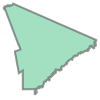

In [8]:
## 2.2 Get geometry for Acrelândia, AC
city = brazilian_municipalities.query('nm_mun == "Acrelândia"') # Filter the geometry for Acrelândia, AC (can be any other city or set of cities)
city_geom = city.geometry.iloc[0] # Get the geometry of Acrelândia, AC
city_geom # See the geometry shape


Having the shapefile we want to study properly saved, we will create a bounding box around it to crop the MapBiomas full raster. Then, we will save it using their GEE Python API.


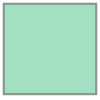

In [9]:
## 2.3 Set the bounding box (bbox) for the area of interest
bbox = city_geom.bounds # Get the bounding box of the geometry
bbox = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])]) # Convert the bounding box to a Polygon

bbox_xmin = bbox.bounds[0] # Get the minimum x coordinate of the bounding box
bbox_ymin = bbox.bounds[1] # Get the minimum y coordinate of the bounding box
bbox_xmax = bbox.bounds[2] # Get the maximum x coordinate of the bounding box
bbox_ymax = bbox.bounds[3] # Get the maximum y coordinate of the bounding box

bbox

In [7]:
plot_geometries_on_osm([bbox, city_geom], zoom_start=10) # Plot the bounding box and the geometry of Acrelandia over an OSM

Now, we will access the MapBiomas Google Earth Engine  API. First, we need to [create a cloud project on GEE](https://dev.to/geedevs-nairobi/creating-an-earth-engine-cloud-project-4gja) using a Google Account. Make sure you have enough space on your Google Drive account.<br>
<br>
Then, we need to authenticate the [GEE Python API](https://developers.google.com/earth-engine/guides/auth) (only the first time). VSCode users, notice that the token insertion box appears in the top right corner of the IDE.<br>
<br>
All images from the MapBiomas LULC Collection are available in the same asset. Notice that you can slightly modify this script to work with other assets in the GEE catalog and other MapBiomas collections.<br>


In [8]:
## 2.4 Acess MapBiomas Collection 8.0 using GEE API
# import ee - already imported in the first cell

ee.Authenticate() # Only for the first time 
ee.Initialize() # Run it every time you start a new session

# Define the MapBiomas Collection 8.0 asset ID - retrieved from https://brasil.mapbiomas.org/en/colecoes-mapbiomas/
mapbiomas_asset = 'projects/mapbiomas-workspace/public/collection8/mapbiomas_collection80_integration_v1'

asset_properties = ee.data.getAsset(mapbiomas_asset) # Check the asset's properties
asset_properties

{'type': 'IMAGE',
 'name': 'projects/earthengine-legacy/assets/projects/mapbiomas-workspace/public/collection8/mapbiomas_collection80_integration_v1',
 'id': 'projects/mapbiomas-workspace/public/collection8/mapbiomas_collection80_integration_v1',
 'updateTime': '2023-08-30T23:56:38.547778Z',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.89759014547877, -34.791885938423874],
    [-74.63230912030016, -34.800832945483485],
    [-74.36697235834127, -34.80920421217146],
    [-74.10158353966743, -34.8169994419629],
    [-73.83614635171017, -34.82421835859891],
    [-73.57066448872823, -34.8308607061315],
    [-73.3051416513314, -34.83692624890563],
    [-73.03958154592364, -34.842414771675955],
    [-72.77398788419997, -34.84732607957095],
    [-72.5083643826075, -34.85165999815575],
    [-72.24271476185136, -34.85541637345913],
    [-71.97704274632875, -34.858595071991424],
    [-71.71135206362588, -34.86119598075355],
    [-71.445646443988, -34.86321900729091],
    [-71.17992961

Here, each band represents the LULC data for a given year. Make sure that the script below is properly written. This script crops the raw raster for a bounding box around the region of interest (ROI) - Acrelândia, AC - for the desired year.


In [9]:
## 2.5 Filter the collection for 2022 and crop the collection to a bbox around Acrelândia, AC
year = 2022
band_id = f'classification_{year}' # bands are named as classification_1985, classification_1986, ..., classification_2022

mapbiomas_image = ee.Image(mapbiomas_asset) # Get the images of MapBiomas Collection 8.0 
mapbiomas2022 = mapbiomas_image.select(band_id) # Select the image for 2022

roi = ee.Geometry.Rectangle([bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax]) # Set the Region of Interest (ROI) to the bbox around Acrelândia, AC
image_roi = mapbiomas2022.clip(roi) # Crop the image to the ROI

Now, we save the cropped raster on Google Drive (in my case, into the 'tutorial_mapbiomas_gee' folder - make sure you have created the destination folder in your drive before running).<br>
<br>
I tried to save it locally, but it looks like GEE doesn't allow this (let me know if someone knows how to do it). This is the most time-consuming part of the code. For large ROIs, this might take hours. Check your GEE task manager to see if the rasters were properly loaded to the destination folder.

In [10]:
## 2.6 Export it to your Google Drive (ensure you have space there and that it is properly set up)
export_task = ee.batch.Export.image.toDrive(
    image=image_roi, # Image to export to Google Drive as a GeoTIFF
    description='clipped_mapbiomas_collection8_acrelandia_ac_2022', # Task description
    folder='tutorial_mapbiomas_gee', # Change this to the folder in your Google Drive where you want to save the file
    fileNamePrefix='acrelandia_ac_2022', # File name (change it if you want to)
    region=roi.getInfo()['coordinates'], # Region to export the image
    scale=30,
    fileFormat='GeoTIFF'
)

# Start the export task
export_task.start()

# 3. Plot it on a Map

We now have a raster with LULC data for a bounding box around Acrelândia in 2022. This is saved at the address below (at Google Drive). First, let's see how it looks.

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2116, 'height': 2069, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002694945852358564, 0.0, -67.19362392602656,
       0.0, -0.0002694945852358564, -9.675664093722954)}
EPSG:4326


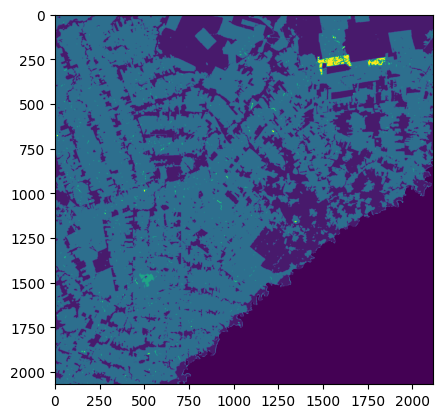

In [4]:
## 3.1 Plot the orginal raster over a OSM 
file_path = '/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/tutorial_mapbiomas_gee/acrelandia_ac_2022.tif' # Change this to the path of the exported file

# Plot data
with rasterio.open(file_path) as src:
    data = src.read(1)
    print(src.meta)
    print(src.crs)
    show(data)

Each pixel in MapBiomas LULC Collection 8 represents a given land use type, according to [this list](https://brasil.mapbiomas.org/wp-content/uploads/sites/4/2023/08/Legenda-Colecao-8-LEGEND-CODE.pdf). For instance, 3 means 'Natural Forest', 15 means 'Pasture', and 0 means 'No data' (pixels in the raster not within the Brazilian borders).<br>
<br>
We will explore the data we have before plotting it.


In [12]:
## 3.2 See unique values 
unique_values = np.unique(data)
unique_values

# 0 = no data, parts of the image outside Brazil

array([ 0,  3,  4,  6, 11, 12, 15, 24, 33, 41], dtype=uint8)

In our case, nearly 70% of the non-zero raster consists of pastureland. The remaining 30% is mostly composed of natural Amazon forest. Note that this data refers to land use in the bounding box we set around Acrelândia. In the next steps, we will crop it to the city limits.<br>
<br>
When dealing with land use shares, make sure you do not include pixels with no data (0), as this will lead to incorrect conclusions.


In [13]:
## 3.3 See frequency of each class (except 0 - no data)
unique_values, counts = np.unique(data[data != 0], return_counts=True) # Get the unique values and their counts (except zero)
pixel_counts = pd.DataFrame({'value': unique_values, 'count': counts})
pixel_counts['share'] = (pixel_counts['count'] / pixel_counts['count'].sum())*100
pixel_counts

,value,count,share
0,3,1057782,30.639575
1,4,8,0.000232
2,6,965,0.027952
3,11,1357,0.039307
4,12,1178,0.034122
5,15,2367366,68.572814
6,24,3159,0.091503
7,33,9462,0.274075
8,41,11062,0.320420


In the end of the day, that's what we are working with: a giant matrix in which each element represents how each tiny 30m x 30m piece of land is used. So, the most upper-left and bottom-left pixels are dedicated to pasture, while the most upper-right one is forested. We don't know how the most bottom-right one is used since it is outside Brazilian limits.


In [14]:
## 3.4 See the actual raster (a matrix in which each element represents a pixel value - land use code in this case)
data 

array([[15, 15, 15, ...,  3,  3,  3],
       [15, 15, 15, ...,  3,  3,  3],
       [15, 15, 15, ...,  3,  3,  3],
       ...,
       [15, 15, 15, ...,  0,  0,  0],
       [15, 15, 15, ...,  0,  0,  0],
       [15, 15, 15, ...,  0,  0,  0]], dtype=uint8)

Now we need to organize our raster. Instead of seeing the exact land use for each single pixel, we want a broader categorization. We will categorize pixels into natural forest, natural non-forest vegetation, water, pasture, agriculture, and other uses. In this specific case, we are interested in observing how natural forest has been converted to pasture. That's why we need to reassign pixel values according to the `mapbiomas_categories` dict below, which mainly uses MapBiomas' own LULC categorization.<br>
<br>
The code snippet below crops the raster to Acrelândia's limits and reassigns pixels according to the `mapbiomas_categories` dict. Then, saves it as a new raster at 'reassigned_raster_path'. Note that the old raster was saved on Google Drive (after being downloaded using GEE's API), while the new one will be saved in the project folder (in my case, a OneDrive folder on my PC, as set in section 1.2). From here onwards, we will use only the so-called reassigned raster to plot the data.<br>
<br>
This is the main part of the script. If you have doubts about what is happening here (cropping for Acrelândia and then reassigning pixels to broader categories), I recommend running it and printing results for every step.<br>


In [26]:
mapbiomas_categories = {
    # Forest (= 3)
    1:3, 3:3, 4:3, 5:3, 6:3, 49:3, # That is, values 1, 3, 4, 5, 6, and 49 will be reassigned to 3 (Forest)
    # Other Non-Forest Natural Vegetation (= 10)
    10:10, 11:10, 12:10, 32:10, 29:10, 50:10, 13:10, # That is, values 10, 11, 12, 32, 29, 50, and 13 will be reassigned to 10 (Other Non-Forest Natural Vegetation)
    # Pasture (= 15)
    15:15, 
    # Agriculture (= 18)
    18:18, 19:18, 39:18, 20:18, 40:18, 62:18, 41:18, 36:18, 46:18, 47:18, 35:18, 48:18, 21:18, 14:18, 9:18, # That is, values 18, 19, 39, 20, 40, 62, 41, 36, 46, 47, 35, 48, 21, 14, and 9 will be reassigned to 18 (Agriculture)
    # Water ( = 26)
    26:26, 33:26, 31:26, # That is, values 26, 33, and 31 will be reassigned to 26 (Water)
    # Other (= 22)
    22:22, 23:22, 24:22, 30:22, 25:22, 27:22, # That is, values 22, 23, 24, 30, 25, and 27 will be reassigned to 22 (Other)
    # No data (= 255)
    0:255 # That is, values 0 will be reassigned to 255 (No data)
}

In [ ]:
## 3.5 Reassing pixels values to the MapBiomas custom general categories and crop it to Acrelandia, AC limits
original_raster_path = '/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/tutorial_mapbiomas_gee/acrelandia_ac_2022.tif' 
reassigned_raster_path = 'reassigned_rasters/acrelandia_ac_2022_reassigned.tif'

with rasterio.open(original_raster_path) as src:
    raster_array = src.read(1)
    out_meta = src.meta.copy() # Get metadata from the original raster


    # 1. Crop (or mask) the raster to the geometry of city_geom (in this case, Acrelandia, AC) and thus remove pixels outside the city limits (will be assigned to no data = 255)
    out_image, out_transform = rasterio.mask.mask(src, [city_geom], crop=True) 
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    }) # Update metadata to the new raster
    raster_array = out_image[0] # Get the masked raster

    modified_raster = np.zeros_like(raster_array) # Base raster full of zeros to be modified


    # 2. Reassign each pixel based on the mapbiomas_categories dictionary
    for original_value, new_value in mapbiomas_categories.items():
        mask = (raster_array == original_value) # Create a boolean mask for the original value (True = Replace, False = Don't replace)
        modified_raster[mask] = new_value # Replace the original values with the new values, when needed (that is, when the mask is True)

    out_meta = src.meta.copy() # Get metadata from the original raster

out_meta.update(dtype=rasterio.uint8, count=1) # Update metadata to the new raster

with rasterio.open(reassigned_raster_path, 'w', **out_meta) as dst: # Write the modified raster to a new file at the reassigned_raster_path
    dst.write(modified_raster.astype(rasterio.uint8), 1)

Notice that we now have fewer unique values, and pixels with no data are assigned the value 255.


In [16]:
with rasterio.open(reassigned_raster_path) as src:
    raster_data = src.read(1)
    unique_values = np.unique(raster_data)
    print(unique_values) # See unique values in the reassigned raster

[  3  10  15  18  22  26 255]


In [19]:
## 3.6 See the frequency of pixels in the reassigned raster
with rasterio.open(reassigned_raster_path) as src:
    raster_data = src.read(1)
    unique_values = np.unique(raster_data)
    total_non_zero = np.sum(raster_data != 255) # Count the total number of non-zero pixels

    for value in unique_values:
        if value != 255:  # Exclude no data (= 255)
            count = np.sum(raster_data == value) # Count the number of pixels with the value
            share = count / total_non_zero # Calculate the share of the value
            share = share.round(3) # Round to 3 decimal places
            print(f"Value: {value}, Count: {count}, Share: {share}") 

Value: 3, Count: 570893, Share: 0.278
Value: 10, Count: 1553, Share: 0.001
Value: 15, Count: 1471755, Share: 0.716
Value: 18, Count: 794, Share: 0.0
Value: 22, Count: 3159, Share: 0.002
Value: 26, Count: 6626, Share: 0.003


Now we plot the data with generic colors. We will enhance the map later, but this is just a first (or second?) look. Note that I specifically set 255 (no data, pixels outside Acrelândia) to be white for better visualization.


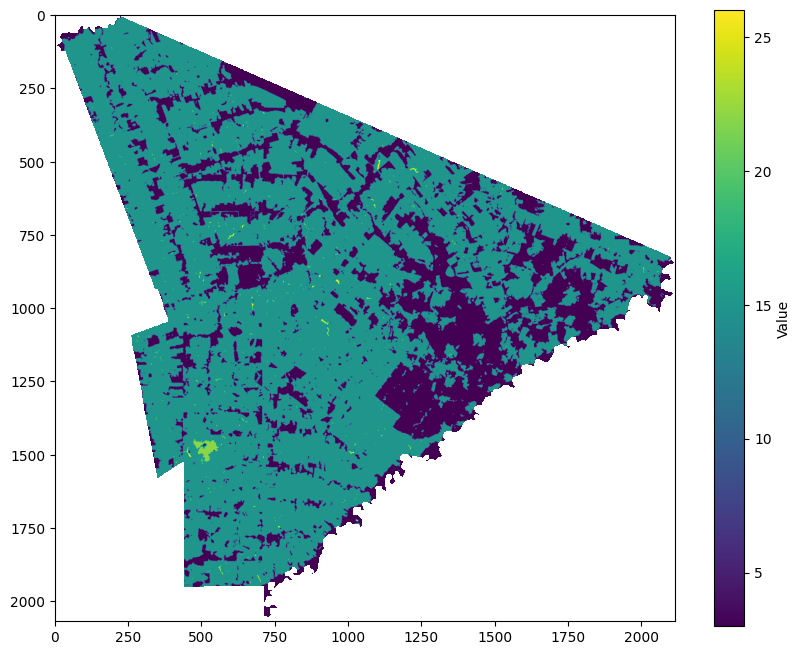

In [20]:
## 3.7 Plot the reassigned raster with generic colors
with rasterio.open(reassigned_raster_path) as src:
    data = src.read(1) # Read the raster data
    unique_values = np.unique(data) # Get the unique values in the raster
    
    plt.figure(figsize=(10, 8)) # Set the figure size
    
    cmap = plt.cm.viridis  # Using Viridis colormap
    norm = Normalize(vmin=data.min(), vmax=26) # Normalize the data to the range of the colormap (max = 26, water)
    
    masked_data = np.ma.masked_where(data == 255, data) # Mask no data values (255)
    plt.imshow(masked_data, cmap=cmap, norm=norm) # Plot the data with the colormap
    
    plt.colorbar(label='Value') # Add a colorbar with the values
    
    plt.show()


Now it's time to create a beautiful map. I chose Matplotlib because I wanted static maps. If you prefer interactive choropleths, you can use [Plotly](https://plotly.com/python/choropleth-maps/).<br>
<br>
For further details on choropleths with Matplotlib, check [its documentation](https://matplotlib.org/stable/users/index.html), GeoPandas [guide](https://geopandas.org/en/stable/docs/user_guide/mapping.html), and the great Yan Holtz's [Python Graph Gallery](https://python-graph-gallery.com) - where I get much of the inspiration and tools for DataViz in Python.<br>
<br>
Make sure you have all data visualization libraries properly loaded to run the code below. Also, I tried to change the order of patches, but I didn't know how to. Let me know if you find out.<br>


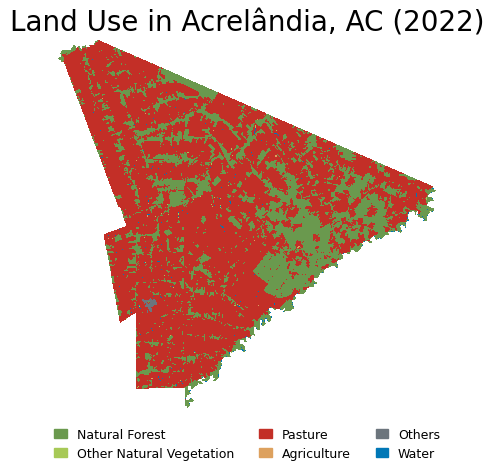

In [29]:
## 3.7 Plot the reassigned raster with custom colors

# Define the colors for each class - notice you need to follow the same order as the values and must be numerically increasing or decreasing (still need to find out how to solve it)
values = [3, 10, 15, 18, 22, 26, 255]  
colors_list = ['#6a994e', '#a7c957', '#c32f27', '#dda15e', '#6c757d', '#0077b6','#FFFFFF']
labels = ['Natural Forest', 'Other Natural Vegetation', 'Pasture', 'Agriculture', 'Others', 'Water', 'No data']

cmap = colors.ListedColormap(colors_list) # Create a colormap (cmap) with the colors
bounds = values + [256] # Add a value to the end of the list to include the last color
norm = colors.BoundaryNorm(bounds, cmap.N) # Normalize the colormap to the values

img = plt.imshow(raster_data, interpolation='nearest', cmap=cmap, norm=norm) # Plot the data with the colormap

legend_patches = [mpatches.Patch(color=colors_list[i], label=labels[i]) for i in range(len(values)-1)] # Create the legend patches withou the last one (255 = no data)

# Create the legend
plt.legend(handles = legend_patches, # Add the legend patches
          bbox_to_anchor = (0.5, -0.02), # Place the legend below the plot
          loc = 'upper center', # Place the legend in the upper center
          ncol = 3, # Number of columns
          fontsize = 9, # Font size
          handlelength=1,# Length of the legend handles
          frameon=False) # Remove the frame around the legend

plt.axis('off') # Remove the axis
plt.title('Land Use in Acrelândia, AC (2022)', fontsize=20) # Add title

plt.savefig('figures/acrelandia_ac_2022.pdf', format='pdf', dpi=1800) # Save it as a PDF at the figures folder
plt.show()

# 4. Do it for Multiple Shapes and Years

We now have intuition built on how to download, save, clean, and plot MapBiomas LULC rasters. It is time to do this generically. In this section, we will define functions that perform all these steps for any region and any year.

First, save a bounding box (bbox) around the desired geometry. You just need to insert the desired geometry and specify the year that this function will use to perform the algorithm.


In [10]:
## 4.1 For a generic geometry in any year, save a bbox around the geometry to Google Drive
def get_mapbiomas_lulc_raster(geom, geom_name, year, folder_in_google_drive):
    ee.Authenticate() # Only for the first time
    ee.Initialize() # Run it every time you start a new session
    
    my_geom = geom
    
    bbox = my_geom.bounds # Get the bounding box of the geometry
    bbox = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1])]) # Convert the bounding box to a Polygon

    bbox_xmin = bbox.bounds[0] # Get the minimum x coordinate of the bounding box
    bbox_ymin = bbox.bounds[1] # Get the minimum y coordinate of the bounding box
    bbox_xmax = bbox.bounds[2] # Get the maximum x coordinate of the bounding box
    bbox_ymax = bbox.bounds[3] # Get the maximum y coordinate of the bounding box
    
    mapbiomas_asset = 'projects/mapbiomas-workspace/public/collection8/mapbiomas_collection80_integration_v1'
    band_id = f'classification_{year}'

    mapbiomas_image = ee.Image(mapbiomas_asset) # Get the images of MapBiomas Collection 8.0 
    mapbiomas_data = mapbiomas_image.select(band_id) # Select the image for 2022

    roi = ee.Geometry.Rectangle([bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax]) # Set the Region of Interest (ROI) to the bbox around the desired geometry
    image_roi = mapbiomas_data.clip(roi) # Crop the image to the ROI
    
    export_task = ee.batch.Export.image.toDrive(
        image=image_roi, # Image to export to Google Drive as a GeoTIFF
        description=f"save_bbox_around_{geom_name}_in_{year}", # Task description
        folder=folder_in_google_drive, # Change this to the folder in your Google Drive where you want to save the file
        fileNamePrefix=f"{geom_name}_{year}", # File name
        region=roi.getInfo()['coordinates'], # Region to export the image
        scale=30,
        fileFormat='GeoTIFF'
    )
    export_task.start()  # Notice that uploading those rasters to Google Drive may take a while, specially for large areas
    

Usage example for Rio de Janeiro in 2022.

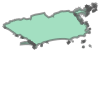

In [11]:
folder_in_google_drive = 'tutorial_mapbiomas_gee'
rio_de_janeiro = brazilian_municipalities.query('nm_mun == "Rio de Janeiro"') #
rio_de_janeiro.crs = 'EPSG:4326' # Set the CRS to WGS84 (this project default one, change if needed)
rio_de_janeiro_geom = rio_de_janeiro.geometry.iloc[0] # Get the geometry of Acrelândia, AC
rio_de_janeiro_geom # See the geometry shape

In [32]:
teste1 = get_mapbiomas_lulc_raster(rio_de_janeiro_geom, 'rio_de_janeiro', 2022, folder_in_google_drive)

Second, crop the raster to include only the pixels within the geometry and save it as a new raster.<br>
<br>
I chose to save it on Google Drive, but you can change `reassigned_raster_path` to save it anywhere else. If you change it, make sure to update the remaining code accordingly.<br>
<br>
Also, you can reassign pixels as needed by modifying the `mapbiomas_categories` dict. The left digit represents the original pixel values, and the right one represents the reassigned (new) values.<br>

In [12]:
## 4.2 Crop the raster for the desired geometry
def crop_mapbiomas_lulc_raster(geom, geom_name, year, folder_in_google_drive):
    original_raster_path = f'/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/{folder_in_google_drive}/{geom_name}_{year}.tif'
    reassigned_raster_path = f'/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/{folder_in_google_drive}/cropped_{geom_name}_{year}.tif'
    
    my_geom = geom

    mapbiomas_categories = {
    # Forest (= 3)
    1:3, 3:3, 4:3, 5:3, 6:3, 49:3,
    # Other Non-Forest Natural Vegetation (= 10)
    10:10, 11:10, 12:10, 32:10, 29:10, 50:10, 13:10,
    # Pasture (= 15)
    15:15,
    # Agriculture (= 18)
    18:18, 19:18, 39:18, 20:18, 40:18, 62:18, 41:18, 36:18, 46:18, 47:18, 35:18, 48:18, 21:18, 14:18, 9:18,
    # Water ( = 26)
    26:26, 33:26, 31:26,
    # Outros (= 22)
    22:22, 23:22, 24:22, 30:22, 25:22, 27:22,
    # No data (= 255)
    0:255
    } # You can change this to whatever categorization you want, but just remember to adapt the colors and labels in the plot
    
    with rasterio.open(original_raster_path) as src:
        raster_array = src.read(1)
        out_meta = src.meta.copy() # Get metadata from the original raster

        # Crop the raster to the geometry of my_geom and thus remove pixels outside the city limits (will be assigned to no data = 0)
        out_image, out_transform = rasterio.mask.mask(src, [my_geom], crop=True) 
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        }) # Update metadata to the new raster
        raster_array = out_image[0] # Get the masked raster

        modified_raster = np.zeros_like(raster_array) # Base raster full of zeros to be modified

        # Reassign each pixel based on the mapbiomas_categories dictionary
        for original_value, new_value in mapbiomas_categories.items():
            mask = (raster_array == original_value) # Create a boolean mask for the original value (True = Replace, False = Don't replace)
            modified_raster[mask] = new_value # Replace the original values with the new values, when needed (that is, when the mask is True)

        out_meta = src.meta.copy() # Get metadata from the original raster

        out_meta.update(dtype=rasterio.uint8, count=1) # Update metadata to the new raster

    with rasterio.open(reassigned_raster_path, 'w', **out_meta) as dst: # Write the modified raster to a new file at the reassigned_raster_path
        dst.write(modified_raster.astype(rasterio.uint8), 1)

Again, running it for Rio de Janeiro in 2022 as a test.

In [35]:
teste2 = crop_mapbiomas_lulc_raster(rio_de_janeiro_geom, 'rio_de_janeiro', 2022, folder_in_google_drive)

Now we see the frequency of each pixel in the cropped reassigned raster.

In [13]:
## 4.3 Plot the cropped raster
def pixel_freq_mapbiomas_lulc_raster(geom_name, year, folder_in_google_drive):
    reassigned_raster_path = f'/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/{folder_in_google_drive}/cropped_{geom_name}_{year}.tif'
    
    with rasterio.open(reassigned_raster_path) as src:
        raster_data = src.read(1)
        unique_values = np.unique(raster_data)
        total_non_zero = np.sum(raster_data != 255) # Count the total number of non-zero pixels

    for value in unique_values:
        if value != 255:  # Exclude no data (= 255)
            count = np.sum(raster_data == value) # Count the number of pixels with the value
            share = count / total_non_zero # Calculate the share of the value
            share = share.round(3)
            print(f"Value: {value}, Count: {count}, Share: {share}") 

In [37]:
teste3 = pixel_freq_mapbiomas_lulc_raster('rio_de_janeiro', 2022, folder_in_google_drive)


Value: 3, Count: 366069, Share: 0.252
Value: 10, Count: 43354, Share: 0.03
Value: 15, Count: 52771, Share: 0.036
Value: 18, Count: 260995, Share: 0.18
Value: 22, Count: 703193, Share: 0.484
Value: 26, Count: 25149, Share: 0.017


And lastly, we plot it on a beautiful map. You can change the arguments below to adjust things like colors, labels, legend position, font sizes, etc. Also, there is an option to choose the format in which you want to save the data (usually PDF or PNG). PDFs are heavier and preserve resolution, while PNGs are lighter but have lower resolution.


In [19]:
## 4.4 Plot the cropped raster
def plot_mapbiomas_lulc_raster(geom_name, year, folder_in_google_drive,driver):
    reassigned_raster_path = f'/Users/vhpf/Library/CloudStorage/GoogleDrive-vh.pires03@gmail.com/My Drive/{folder_in_google_drive}/cropped_{geom_name}_{year}.tif'
    with rasterio.open(reassigned_raster_path) as src:
        raster_data = src.read(1)

    # Define the colors for each class - notice you need to follow the same order as the values
    values = [3, 10, 15, 18, 22, 26, 255] # Must be the same of the mapbiomas_categories dictionary
    colors_list = ['#6a994e', '#a7c957', '#c32f27', '#dda15e', '#6c757d', '#0077b6','#FFFFFF'] # Set your colors
    labels = ['Natural Forest', 'Other Natural Vegetation', 'Pasture', 'Agriculture', 'Others', 'Water', 'No data'] # Set your labels

    cmap = colors.ListedColormap(colors_list) # Create a colormap (cmap) with the colors
    bounds = values + [256] # Add a value to the end of the list to include the last color
    norm = colors.BoundaryNorm(bounds, cmap.N) # Normalize the colormap to the values

    img = plt.imshow(raster_data, interpolation='nearest', cmap=cmap, norm=norm) # Plot the data with the colormap

    legend_patches = [mpatches.Patch(color=colors_list[i], label=labels[i]) for i in range(len(values)-1)] # Create the legend patches without the last one (255 = no data)

    # Create the legend
    plt.legend(handles = legend_patches, # Add the legend patches
               bbox_to_anchor = (0.5, -0.02), # Place the legend below the plot
               loc = 'upper center', # Place the legend in the upper center
               ncol = 3, # Number of columns
               fontsize = 9, # Font size
               handlelength=1.5,# Length of the legend handles
               frameon=False) # Remove the frame around the legend

    plt.axis('off') # Remove the axis
    geom_name_title = inflection.titleize(geom_name)
    plt.title(f'Land Use in {geom_name_title} ({year})', fontsize=20) # Add title

    saving_path = f'figures/{geom_name}_{year}.{driver}'

    plt.savefig(saving_path, format=driver, dpi=1800) # Save it as a .pdf or .png at the figures folder of your project
    plt.show()

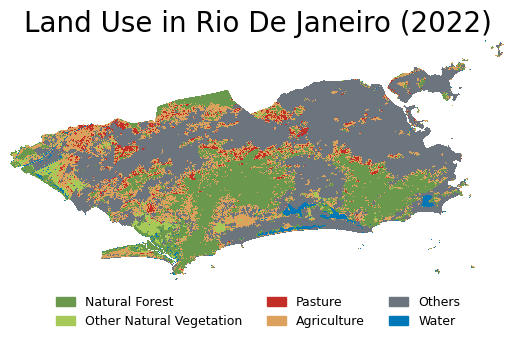

In [20]:
teste4 = plot_mapbiomas_lulc_raster('rio_de_janeiro', 2022, folder_in_google_drive, 'png')

Finally, here's an example of how to use the functions and create a loop to get the LULC evolution for Porto Acre since 1985. That's another city in the Amacro region with soaring deforestation rates. We will finish the tutorial by creating a short video showing the evolution of deforestation in the municipality over the last four decades. Note that you can extend the analysis to multiple cities and select specific years for the analysis. Feel free to customize the algorithm as needed.


In [21]:
## 4.5 Do it in just one function - recall to save rasters before
def clean_mapbiomas_lulc_raster(geom, geom_name, year, folder_in_google_drive,driver):
    crop_mapbiomas_lulc_raster(geom, geom_name, year, folder_in_google_drive)
    plot_mapbiomas_lulc_raster(geom_name, year, folder_in_google_drive,driver)
    print(f"MapBiomas LULC raster for {geom_name} in {year} cropped and plotted!")

In [23]:
## 4.6 Run it for multiple geometries for multiple years

### 4.6.1 First, save rasters for multiple geometries and years
cities_list = ['Porto Acre'] # Cities to be analyzed - check whether there are two cities in Brazil with the same name
years = range(1985,2023) # Years to be analyzed (first year in MapBiomas LULC == 1985)

brazilian_municipalities = gpd.read_file('municipios/file.shp', engine='pyogrio', use_arrow=True) # Read the shapefile - you can use any other shapefile here
brazilian_municipalities = brazilian_municipalities.clean_names()
brazilian_municipalities.crs = 'EPSG:4326' # Set the CRS to WGS84 (this project default one, change if needed)
selected_cities = brazilian_municipalities.query('nm_mun in @cities_list') # Filter the geometry for the selected cities
selected_cities = selected_cities.reset_index(drop=True) # Reset the index

cities_ufs = [] # Create list to append the full names of the cities with their UF (state abbreviation, in portuguese)
nrows = len(selected_cities)
for i in range(nrows):
    city = selected_cities.iloc[i]
    city_name = city['nm_mun']
    city_uf = city['sigla_uf']
    cities_ufs.append(f"{city_name} - {city_uf}")

selected_cities

,cd_mun,nm_mun,sigla_uf,area_km2,geometry
0,1200807,Porto Acre,AC,2604.417,"POLYGON ((-67.70283 -9.78737, -67.70325 -9.786..."


In [48]:
folder_in_google_drive = 'tutorial_mapbiomas_gee' # Folder in Google Drive to save the rasters
for city in cities_list:
    for year in years:
        city_geom = selected_cities.query(f'nm_mun == "{city}"').geometry.iloc[0] # Get the geometry of the city
        geom_name = unidecode.unidecode(city) # Remove latin-1 characters from the city name - GEE doesn`t allow them
        get_mapbiomas_lulc_raster(city_geom, geom_name, year, folder_in_google_drive) # Run the function for each city and year

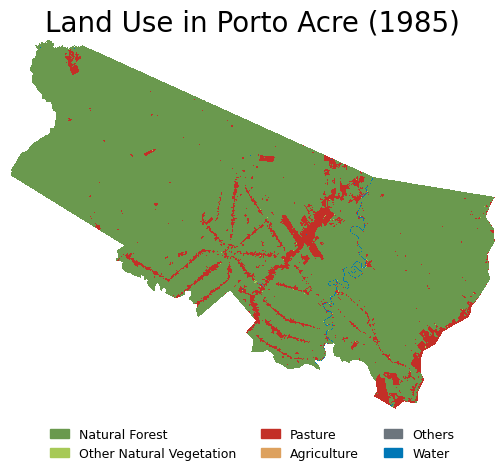

MapBiomas LULC raster for Porto Acre in 1985 cropped and plotted!


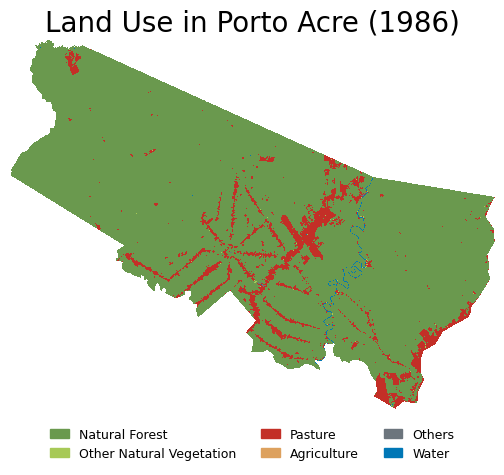

MapBiomas LULC raster for Porto Acre in 1986 cropped and plotted!


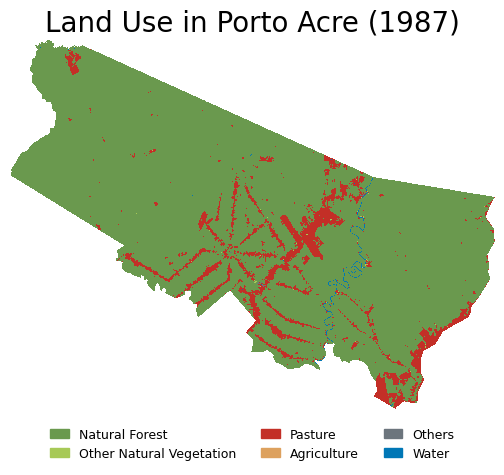

MapBiomas LULC raster for Porto Acre in 1987 cropped and plotted!


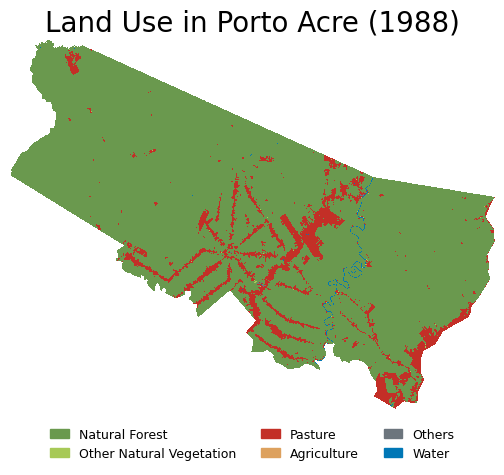

MapBiomas LULC raster for Porto Acre in 1988 cropped and plotted!


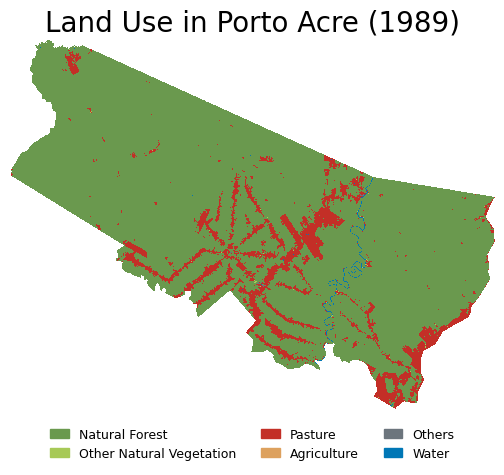

MapBiomas LULC raster for Porto Acre in 1989 cropped and plotted!


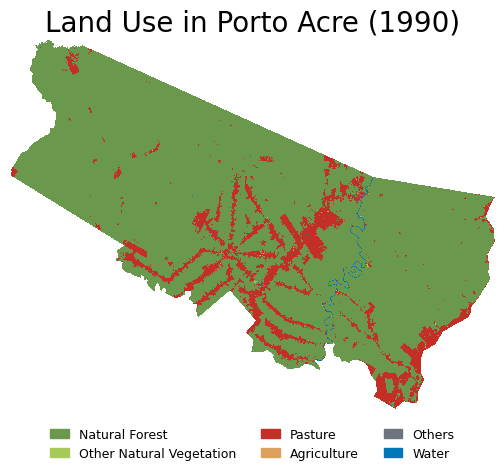

MapBiomas LULC raster for Porto Acre in 1990 cropped and plotted!


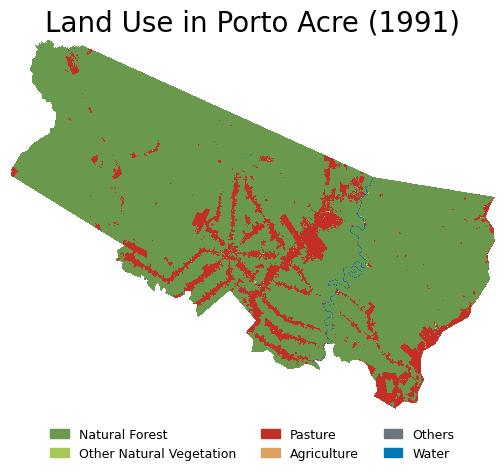

MapBiomas LULC raster for Porto Acre in 1991 cropped and plotted!


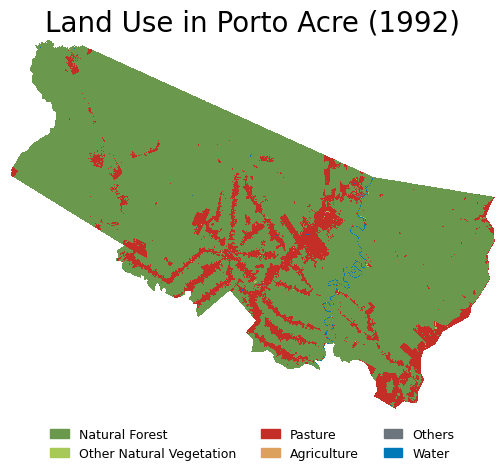

MapBiomas LULC raster for Porto Acre in 1992 cropped and plotted!


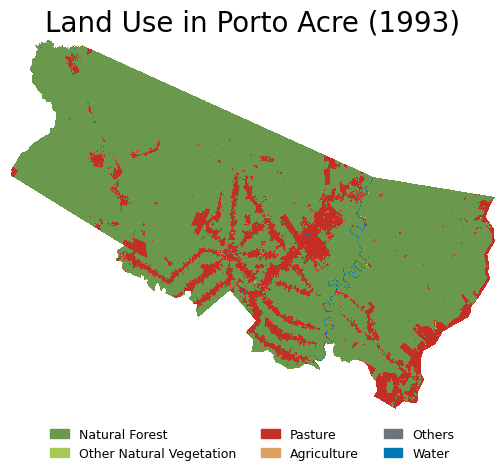

MapBiomas LULC raster for Porto Acre in 1993 cropped and plotted!


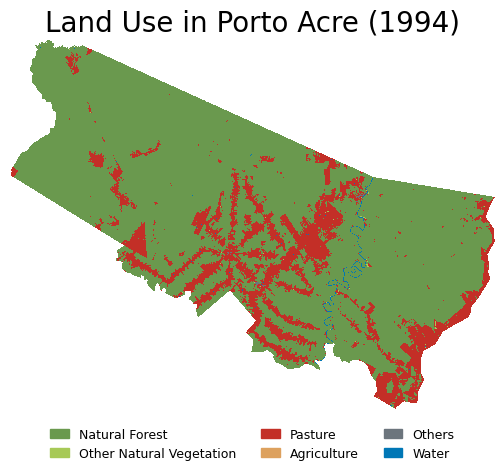

MapBiomas LULC raster for Porto Acre in 1994 cropped and plotted!


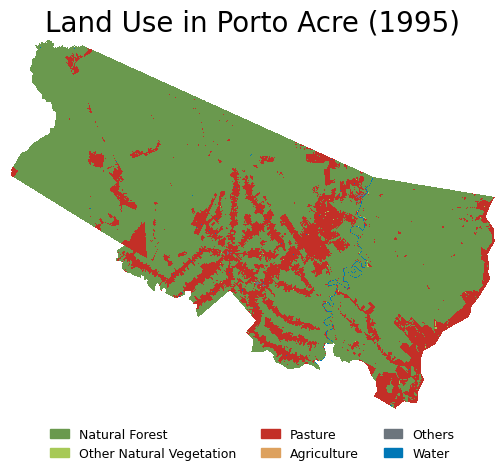

MapBiomas LULC raster for Porto Acre in 1995 cropped and plotted!


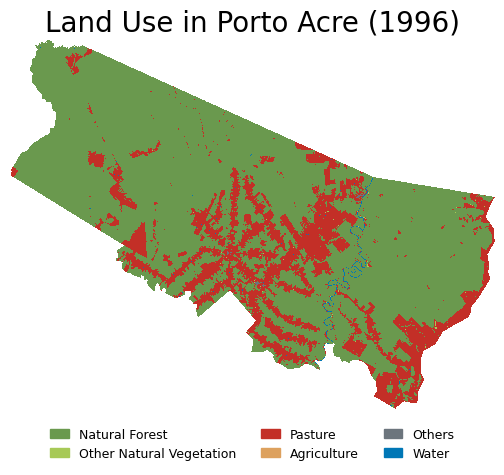

MapBiomas LULC raster for Porto Acre in 1996 cropped and plotted!


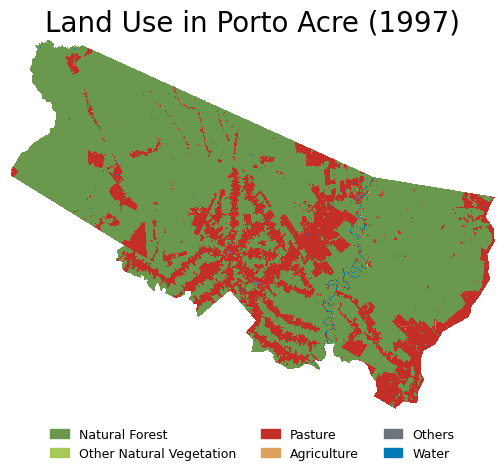

MapBiomas LULC raster for Porto Acre in 1997 cropped and plotted!


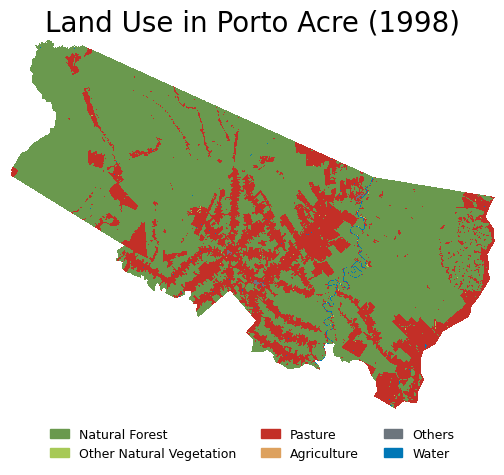

MapBiomas LULC raster for Porto Acre in 1998 cropped and plotted!


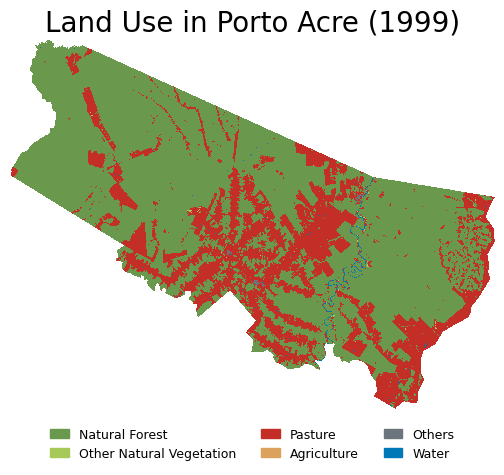

MapBiomas LULC raster for Porto Acre in 1999 cropped and plotted!


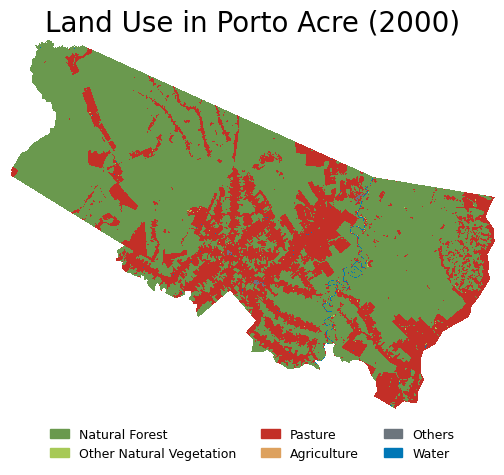

MapBiomas LULC raster for Porto Acre in 2000 cropped and plotted!


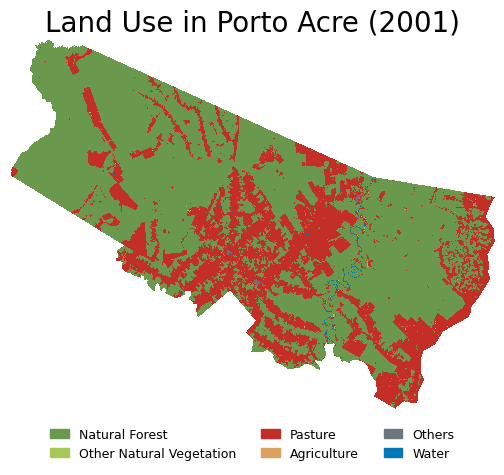

MapBiomas LULC raster for Porto Acre in 2001 cropped and plotted!


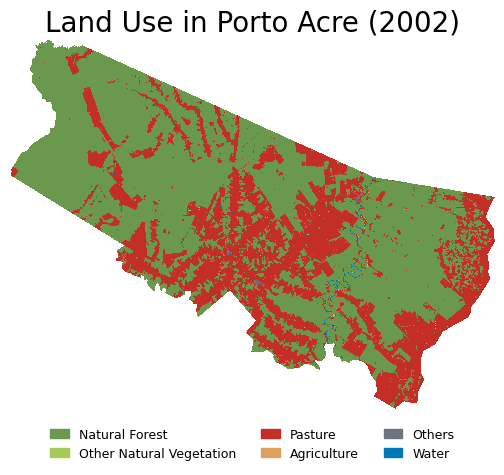

MapBiomas LULC raster for Porto Acre in 2002 cropped and plotted!


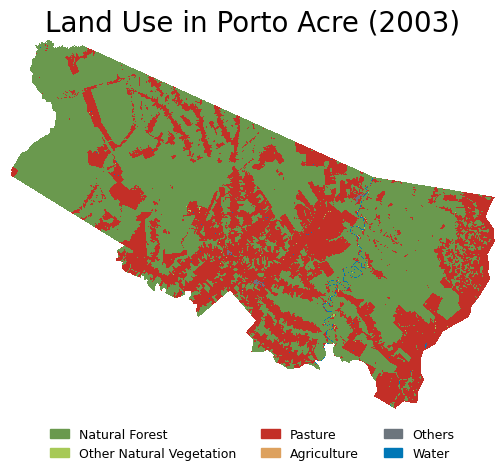

MapBiomas LULC raster for Porto Acre in 2003 cropped and plotted!


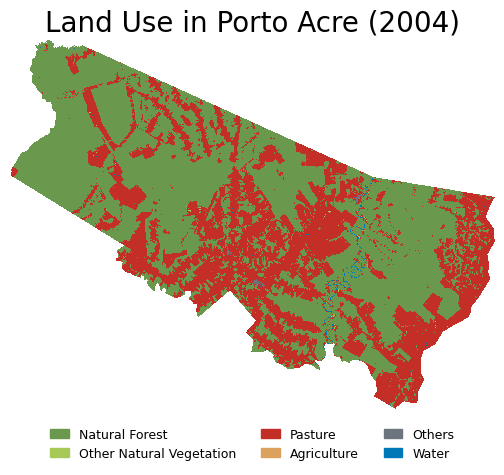

MapBiomas LULC raster for Porto Acre in 2004 cropped and plotted!


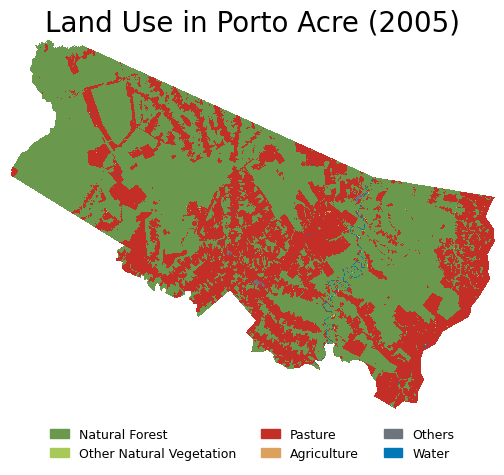

MapBiomas LULC raster for Porto Acre in 2005 cropped and plotted!


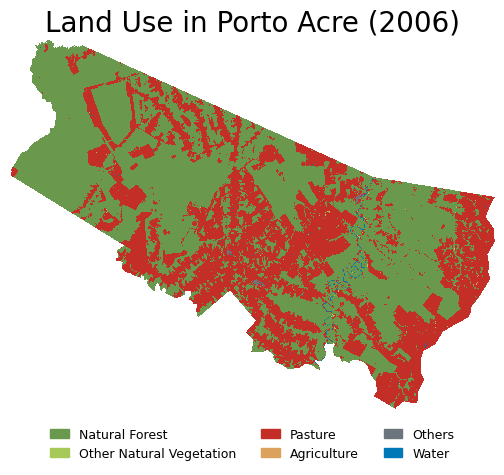

MapBiomas LULC raster for Porto Acre in 2006 cropped and plotted!


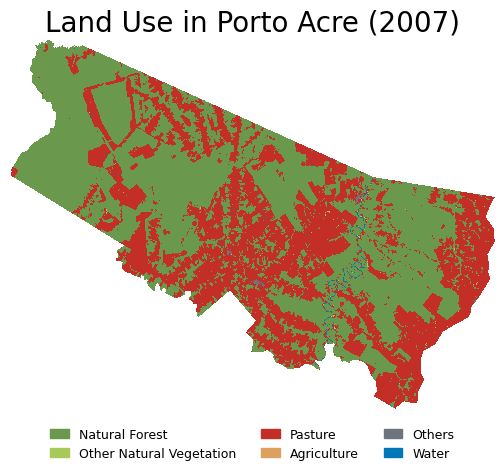

MapBiomas LULC raster for Porto Acre in 2007 cropped and plotted!


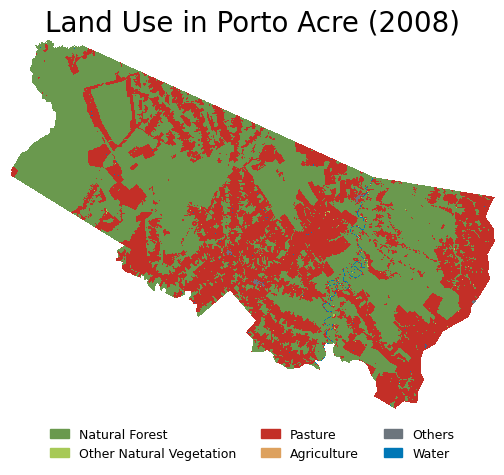

MapBiomas LULC raster for Porto Acre in 2008 cropped and plotted!


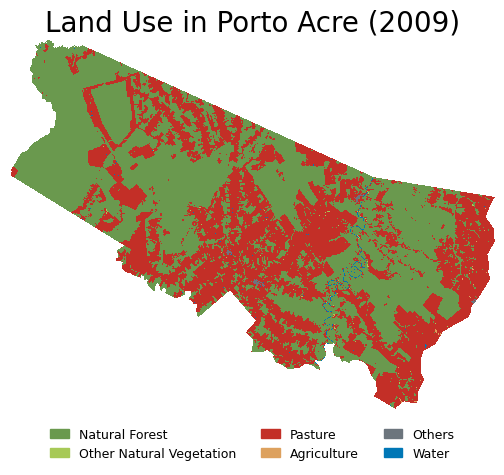

MapBiomas LULC raster for Porto Acre in 2009 cropped and plotted!


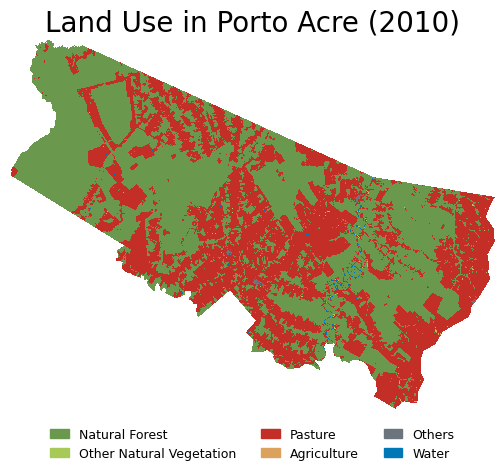

MapBiomas LULC raster for Porto Acre in 2010 cropped and plotted!


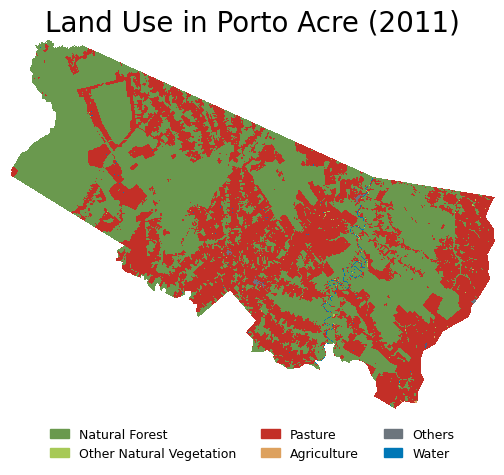

MapBiomas LULC raster for Porto Acre in 2011 cropped and plotted!


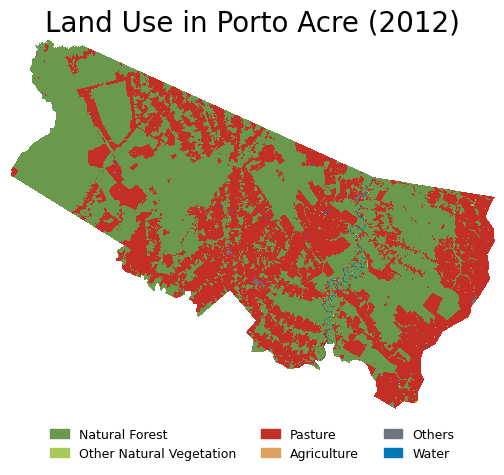

MapBiomas LULC raster for Porto Acre in 2012 cropped and plotted!


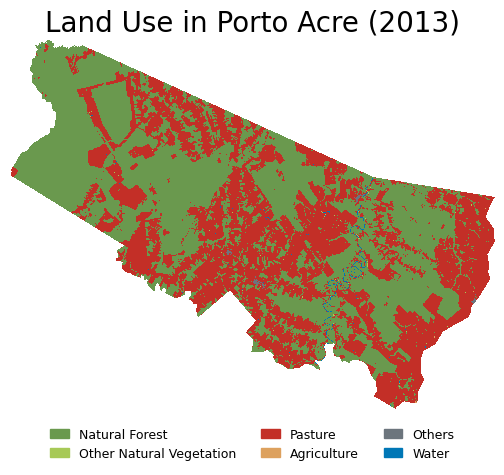

MapBiomas LULC raster for Porto Acre in 2013 cropped and plotted!


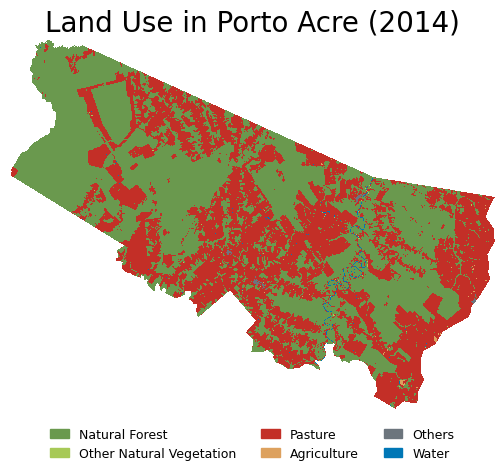

MapBiomas LULC raster for Porto Acre in 2014 cropped and plotted!


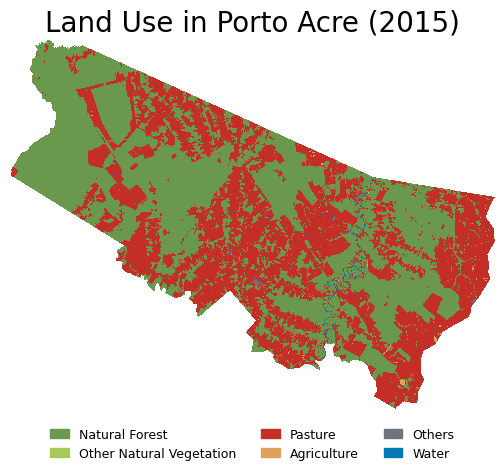

MapBiomas LULC raster for Porto Acre in 2015 cropped and plotted!


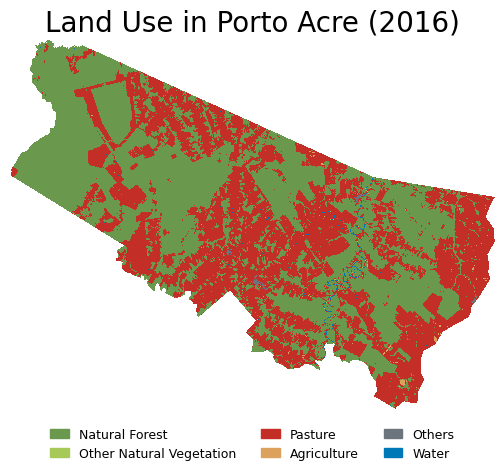

MapBiomas LULC raster for Porto Acre in 2016 cropped and plotted!


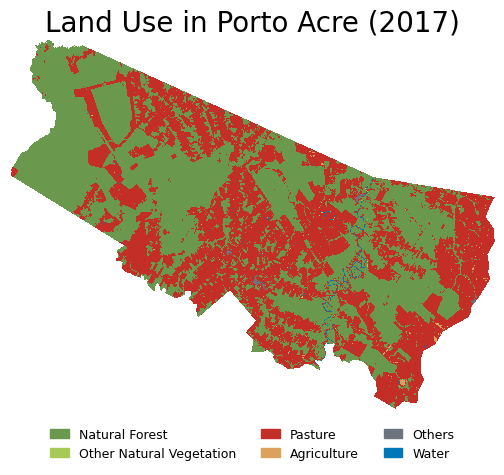

MapBiomas LULC raster for Porto Acre in 2017 cropped and plotted!


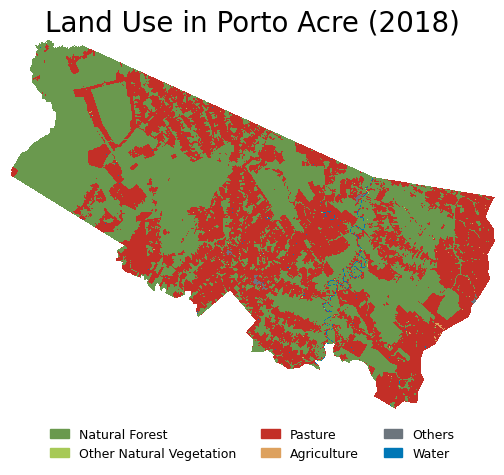

MapBiomas LULC raster for Porto Acre in 2018 cropped and plotted!


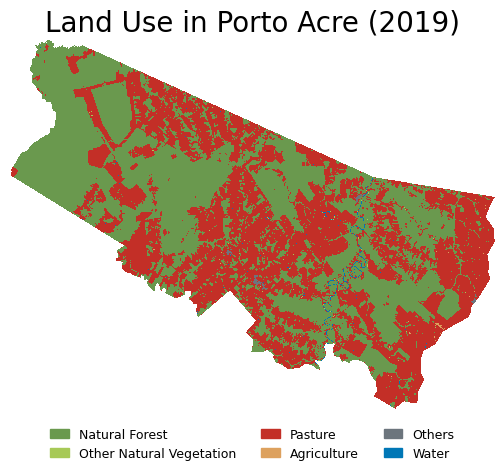

MapBiomas LULC raster for Porto Acre in 2019 cropped and plotted!


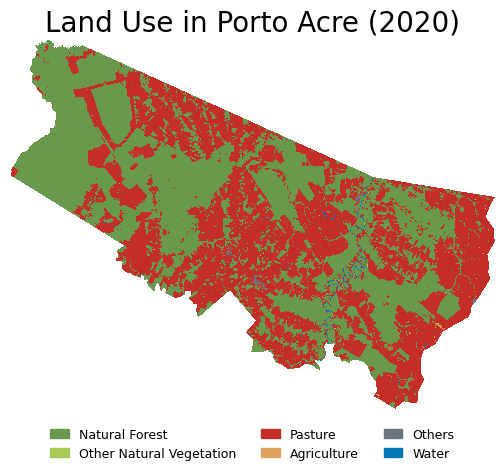

MapBiomas LULC raster for Porto Acre in 2020 cropped and plotted!


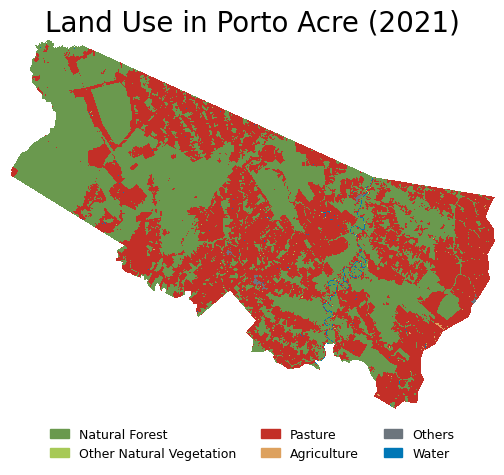

MapBiomas LULC raster for Porto Acre in 2021 cropped and plotted!


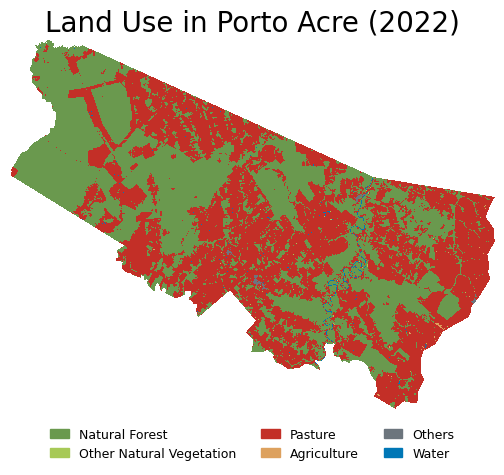

MapBiomas LULC raster for Porto Acre in 2022 cropped and plotted!


In [25]:
### 4.6.2 Second, crop and plot the rasters for multiple geometries and years - Make sure you have enough space in your Google Drive and all rasters are there
for city in cities_list:
    for year in years:
        city_geom = selected_cities.query(f'nm_mun == "{city}"').geometry.iloc[0]
        geom_name = unidecode.unidecode(city)
        clean_mapbiomas_lulc_raster(city_geom, geom_name, year, folder_in_google_drive,'png') # Run the function for each city and year
        gc.collect()

In [6]:
## 4.7 Make a clip with LULC evolution
img_folder = 'figures/porto_acre_lulc' # I created a folder to save the images of the LULC evolution for Porto Acre inside project_path/figures
img_files = sorted([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.endswith('.png')]) # Gets all the images in the folder that  end with .png - make sure you only have the desired images in the folder
img_files

['figures/porto_acre_lulc/Porto Acre_1985.png',
 'figures/porto_acre_lulc/Porto Acre_1986.png',
 'figures/porto_acre_lulc/Porto Acre_1987.png',
 'figures/porto_acre_lulc/Porto Acre_1988.png',
 'figures/porto_acre_lulc/Porto Acre_1989.png',
 'figures/porto_acre_lulc/Porto Acre_1990.png',
 'figures/porto_acre_lulc/Porto Acre_1991.png',
 'figures/porto_acre_lulc/Porto Acre_1992.png',
 'figures/porto_acre_lulc/Porto Acre_1993.png',
 'figures/porto_acre_lulc/Porto Acre_1994.png',
 'figures/porto_acre_lulc/Porto Acre_1995.png',
 'figures/porto_acre_lulc/Porto Acre_1996.png',
 'figures/porto_acre_lulc/Porto Acre_1997.png',
 'figures/porto_acre_lulc/Porto Acre_1998.png',
 'figures/porto_acre_lulc/Porto Acre_1999.png',
 'figures/porto_acre_lulc/Porto Acre_2000.png',
 'figures/porto_acre_lulc/Porto Acre_2001.png',
 'figures/porto_acre_lulc/Porto Acre_2002.png',
 'figures/porto_acre_lulc/Porto Acre_2003.png',
 'figures/porto_acre_lulc/Porto Acre_2004.png',
 'figures/porto_acre_lulc/Porto Acre_200

In [8]:
clip = ImageSequenceClip(img_files, fps=2)  # 2 FPS, 0.5 second between frames

output_file = 'figures/clips/porto_acre_lulc.mp4' # Save clip at the clips folder
clip.write_videofile(output_file, codec='libx264') # It takes a while to create the video (3m30s in my pc)


Moviepy - Building video figures/clips/porto_acre_lulc.mp4.
Moviepy - Writing video figures/clips/porto_acre_lulc.mp4



Moviepy - Done !
Moviepy - video ready figures/clips/porto_acre_lulc.mp4
